<a href="https://colab.research.google.com/github/2303A52243/EXPLAINABLE-AI-LAB/blob/main/EX_AI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install lime shap scikit-learn pandas matplotlib seaborn

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.inspection import PartialDependenceDisplay

import shap
from lime.lime_tabular import LimeTabularExplainer


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=c446eb8ef9ddab934382f09c8da9c7460771af0bbca93ae961f28ab85eaba7a0
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Paths
DATA_PATH = "/content/drive/MyDrive/framingham.csv"   # <-- put file in Drive
OUTDIR = "/content/drive/MyDrive/framingham_explain_outputs"
os.makedirs(OUTDIR, exist_ok=True)

# Load dataset
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
display(df.head())


Mounted at /content/drive
Raw shape: (4240, 16)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [ ]:
# Target column (in Framingham dataset it's usually 'TenYearCHD')
target_col = 'TenYearCHD'
if target_col not in df.columns:
    raise ValueError(f"Target column '{target_col}' not found in dataset.")

X = df.drop(columns=[target_col])
y = df[target_col]

print("\nFeature dtypes summary:")
print(X.dtypes.value_counts())

# Handle missing values
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)



Feature dtypes summary:
float64    9
int64      6
Name: count, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/test sizes:", X_train.shape, X_test.shape)

clf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced"
)
print("\nTraining RandomForest...")
clf.fit(X_train, y_train)


Train/test sizes: (3392, 15) (848, 15)

Training RandomForest...


RandomForestClassifier(class_weight='balanced', n_estimators=300,
                       random_state=42)


Classification report:
              precision    recall  f1-score   support

           0     0.8504    0.9958    0.9174       719
           1     0.5000    0.0233    0.0444       129

    accuracy                         0.8479       848
   macro avg     0.6752    0.5095    0.4809       848
weighted avg     0.7971    0.8479    0.7846       848

Accuracy: 0.847877358490566


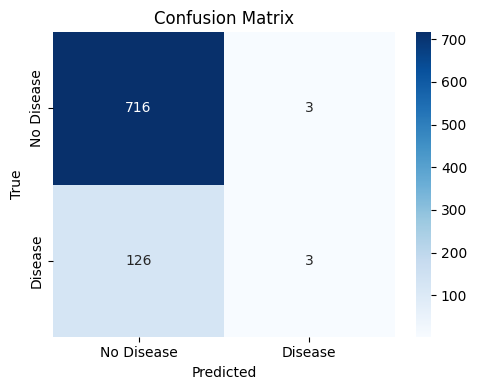

Saved confusion matrix to: /content/drive/MyDrive/framingham_explain_outputs/confusion_matrix.png


In [ ]:
y_pred = clf.predict(X_test)

print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=4))
print("Accuracy:", accuracy_score(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Disease','Disease'],
            yticklabels=['No Disease','Disease'])
plt.ylabel("True")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.tight_layout()
cm_path = os.path.join(OUTDIR, "confusion_matrix.png")
plt.savefig(cm_path, dpi=150)
plt.show()
print("Saved confusion matrix to:", cm_path)



Top features by RF importance: ['age', 'sysBP', 'BMI', 'totChol', 'diaBP', 'glucose', 'heartRate', 'cigsPerDay']


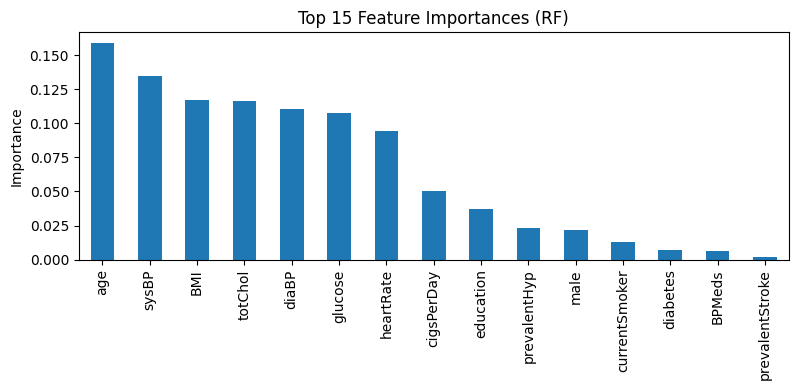

Saved feature importances to: /content/drive/MyDrive/framingham_explain_outputs/feature_importances.png


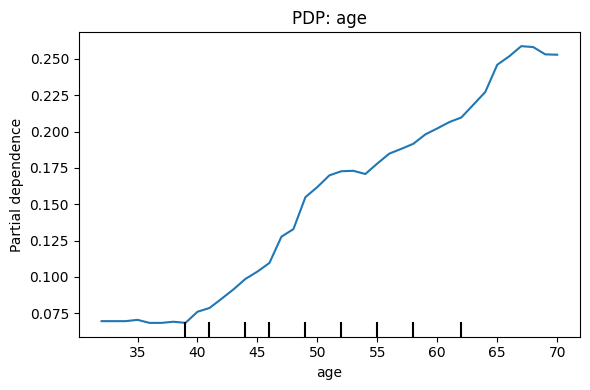

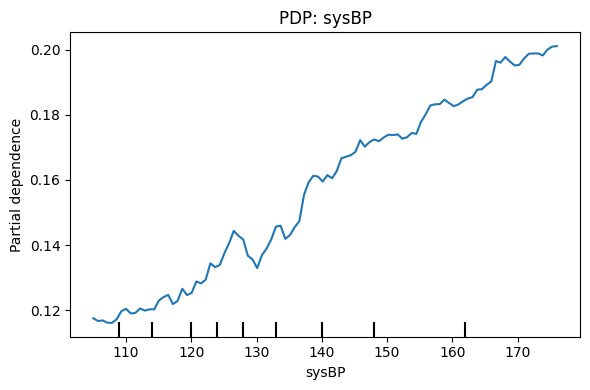

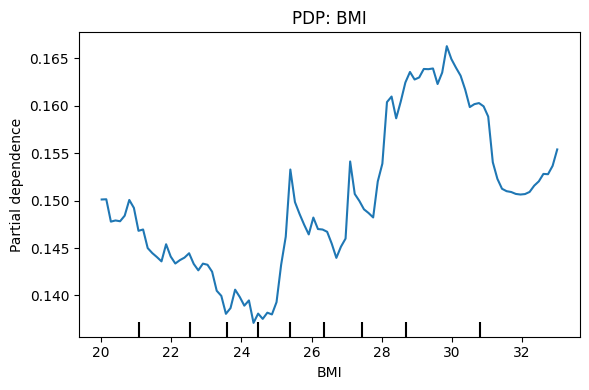

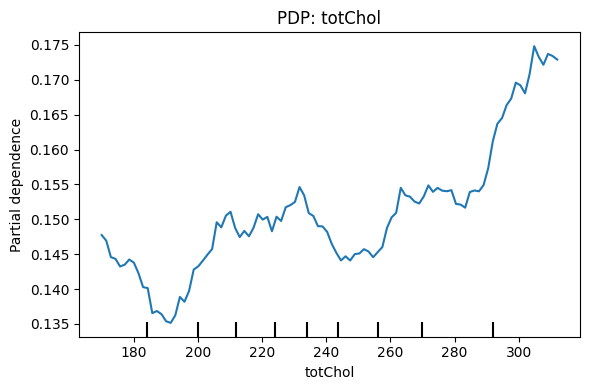

In [ ]:
feat_imp = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_imp_sorted = feat_imp.sort_values(ascending=False)
top_features = feat_imp_sorted.index[:8].tolist()
print("\nTop features by RF importance:", top_features)

plt.figure(figsize=(8,4))
feat_imp_sorted[:15].plot(kind='bar')
plt.title("Top 15 Feature Importances (RF)")
plt.ylabel("Importance")
plt.tight_layout()
imp_path = os.path.join(OUTDIR, "feature_importances.png")
plt.savefig(imp_path, dpi=150)
plt.show()
print("Saved feature importances to:", imp_path)

# PDP for top features
for feat in top_features[:4]:
    fig, ax = plt.subplots(figsize=(6,4))
    PartialDependenceDisplay.from_estimator(clf, X_train, [feat], ax=ax)
    ax.set_title(f"PDP: {feat}")
    fig.tight_layout()
    ppath = os.path.join(OUTDIR, f"pdp_{feat}.png")
    fig.savefig(ppath, dpi=150)
    plt.show()


 99%|===================| 1687/1696 [02:29<00:00]       

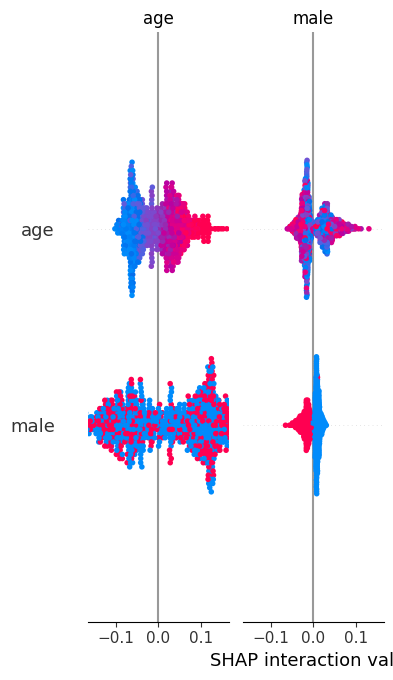

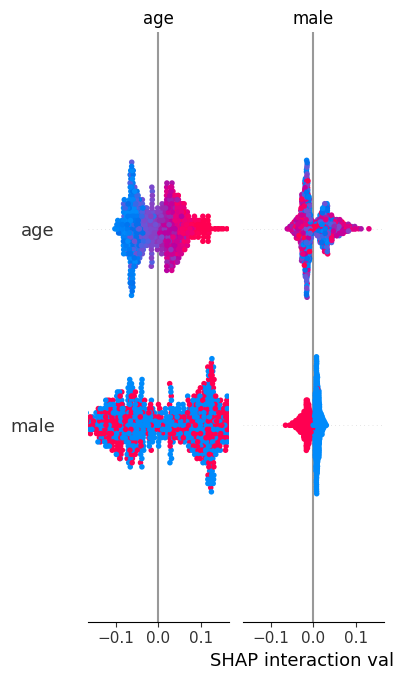

In [ ]:
shap_out_dir = os.path.join(OUTDIR, "shap")
os.makedirs(shap_out_dir, exist_ok=True)

explainer = shap.Explainer(clf, X_train)   # unified API
shap_values = explainer(X_test)

# Bar plot
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
plt.savefig(os.path.join(shap_out_dir, "shap_summary_bar.png"), dpi=150, bbox_inches="tight")
plt.show()

# Beeswarm
shap.summary_plot(shap_values, X_test, show=False)
plt.savefig(os.path.join(shap_out_dir, "shap_beeswarm.png"), dpi=150, bbox_inches="tight")
plt.show()



In [ ]:
lime_out_dir = os.path.join(OUTDIR, "lime")
os.makedirs(lime_out_dir, exist_ok=True)

lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=['No Disease', 'Disease'],
    mode='classification'
)

instance_idx = 5
instance = X_test.iloc[instance_idx]
exp = lime_explainer.explain_instance(
    data_row=instance.values,
    predict_fn=clf.predict_proba,
    num_features=10
)

lime_html_path = os.path.join(lime_out_dir, "lime_explanation_instance.html")
exp.save_to_file(lime_html_path)
print("Saved LIME explanation to:", lime_html_path)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Saved LIME explanation to: /content/drive/MyDrive/framingham_explain_outputs/lime/lime_explanation_instance.html


In [ ]:
save_df = X_test.copy().reset_index(drop=True)
save_df['y_true'] = y_test.reset_index(drop=True)
save_df['y_pred'] = clf.predict(X_test)
save_df['pred_proba_disease'] = clf.predict_proba(X_test)[:,1]

small_save = save_df[[*top_features[:8], 'y_true', 'y_pred', 'pred_proba_disease']].head(50)
csv_out = os.path.join(OUTDIR, "test_preview_topfeatures_preds.csv")
small_save.to_csv(csv_out, index=False)
print("Saved preview CSV to:", csv_out)


Saved preview CSV to: /content/drive/MyDrive/framingham_explain_outputs/test_preview_topfeatures_preds.csv
